#COVID-19 detection through Chest X-rays

##Imports

In [2]:
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import random
import os
from colorama import Fore
import matplotlib.pyplot as plt
from PIL import Image
from skimage import exposure
from skimage.transform import resize
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Dense
from keras.applications import Xception
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

##Data Uploading

In [4]:
#clone the dataset from the github repository
! git clone https://github.com/education454/datasets.git

Cloning into 'datasets'...
remote: Enumerating objects: 2301, done.
remote: Total 2301 (delta 0), reused 0 (delta 0), pack-reused 2301
Receiving objects: 100% (2301/2301), 1.31 GiB | 17.55 MiB/s, done.
Checking out files: 100% (2295/2295), done.


##Data Visualization

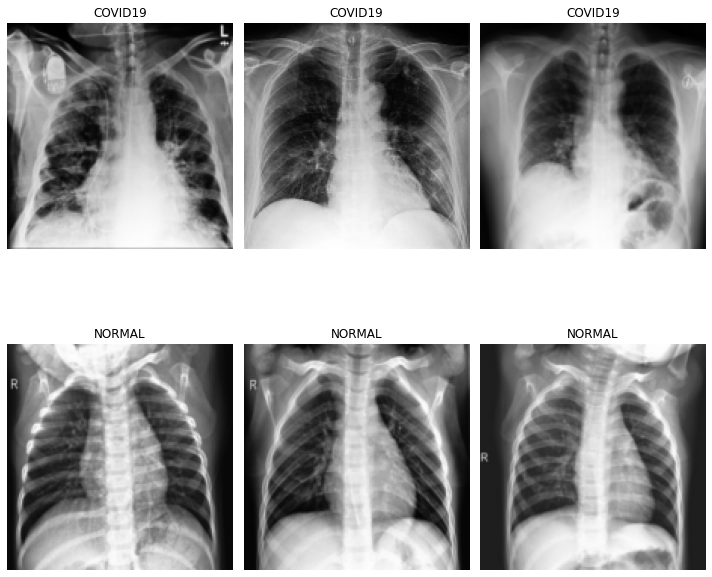

In [9]:
# plot a grid of 6 images (3 images of Covid19 and 3 images of Normal)

TRAIN_DATADIR= '/content/data/train'
CATEGORIES = ["COVID19", "NORMAL"]

figure, axis = plt.subplots(2, 3, figsize=(10, 10))

for category in CATEGORIES:
  path = os.path.join(TRAIN_DATADIR,category)
  img_array = random.sample(os.listdir(path), 3)

  for i in range(3):
    path_img = os.path.join(path,img_array[i])
    image= plt.imread(path_img)
    row = CATEGORIES.index(category)
    axis[row, i].imshow(resize(image, (150, 150, 3)))
    axis[row, i].axis('off')
    axis[row,i].set_title(category)
plt.tight_layout()
plt.show()

##Enhancing contrast

In [5]:
"""Creating floders to store the enhanced data""" 

# set the path to the main dir
MAIN_PATH = '/content/data'

# creating the main folder
os.mkdir(MAIN_PATH)

# creating folders for the training and testing data
os.mkdir(MAIN_PATH + '/train')
os.mkdir(MAIN_PATH + '/train/COVID19')
os.mkdir(MAIN_PATH + '/train/NORMAL')
os.mkdir(MAIN_PATH + '/test')
os.mkdir(MAIN_PATH + '/test/COVID19')
os.mkdir(MAIN_PATH + '/test/NORMAL')

In [6]:
""" The following function do the histogram equalization for all images and write them to a new file directory """

def contrast_enhancement(folder):
  # path of the folder containing the raw images
  INPATH = os.path.join('/content/datasets/Data',folder)

  # path of the folder to store the processed images
  OUTPATH = os.path.join('/content/data',folder)
  dirs = os.listdir(INPATH)
  # iterating over the images and enhancing the contrast of each one
  for item in dirs:
    img = Image.open(os.path.join(INPATH,item)).convert('RGB')
    img_eq = exposure.equalize_hist(np.array(img))
    img_eq = Image.fromarray((img_eq * 255).astype(np.uint8))
    img_eq.save(os.path.join(OUTPATH,item))

In [7]:
# contrast enhancement of the train and test data
contrast_enhancement('train/COVID19')
contrast_enhancement('test/COVID19')
contrast_enhancement('train/NORMAL')
contrast_enhancement('test/NORMAL')

/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


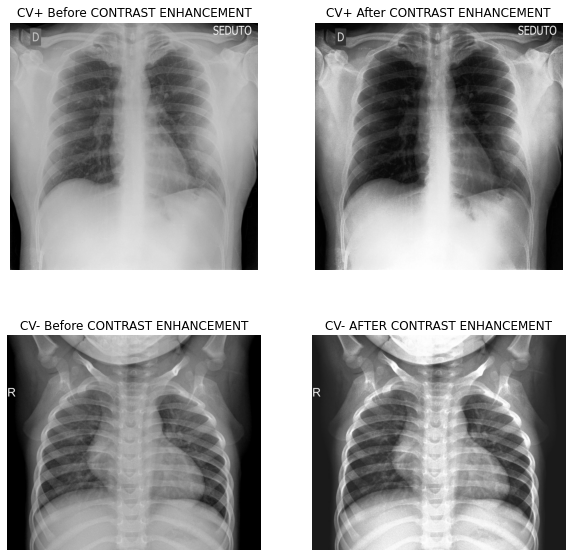

In [8]:
# plotting the same images before and after contrast enhancement

first_img = '/content/datasets/Data/train/COVID19/COVID-19 (354).jpg'
second_img= '/content/datasets/Data/train/NORMAL/NORMAL(1101).jpg'
first_image_eq = '/content/data/train/COVID19/COVID-19 (354).jpg'
second_image_eq = '/content/data/train/NORMAL/NORMAL(1101).jpg'

first_img= plt.imread(first_img)
second_img= plt.imread(second_img)
first_image_eq= plt.imread(first_image_eq)
second_image_eq= plt.imread(second_image_eq)

fig, ax = plt.subplots(2,2,figsize=(10, 10))

ax[0,0].imshow(first_img, cmap= 'gray')
ax[0,0].set_title('CV+ Before CONTRAST ENHANCEMENT')
ax[0,0].axis('off')
ax[0,1].axis('off')
ax[0,1].set_title('CV+ After CONTRAST ENHANCEMENT')
ax[0,1].imshow(first_image_eq)


ax[1,0].imshow(second_img,  cmap= 'gray')
ax[1,0].set_title('CV- Before CONTRAST ENHANCEMENT')
ax[1,0].axis('off')
ax[1,1].axis('off')
ax[1,1].set_title('CV- AFTER CONTRAST ENHANCEMENT')
ax[1,1].imshow(second_image_eq)

##Data Preprocessing and Augmentation

In [10]:
# create and configure the data generator by passing in the augmentation parameters in the constructor
# the generator will rescale and resize the images as well

train_data_generator = ImageDataGenerator(rescale = 1./255,
                                validation_split=0.2,
                                zoom_range = 0.2,
                                rotation_range=45,
                                featurewise_center=True,
                                featurewise_std_normalization=True,
                                zca_whitening=True,
                                horizontal_flip = True,
                                channel_shift_range = 20,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                fill_mode= 'constant'
                                )


# get batch iterator for training
train_generator = train_data_generator.flow_from_directory(TRAIN_DATADIR,
                                                 target_size=(150,150),
                                                 subset = 'training',
                                                 batch_size = 32,
                                                 shuffle=True,
                                                 seed=21,
                                                 class_mode = 'binary')

# get batch iterator for validation
validation_generator = train_data_generator.flow_from_directory(TRAIN_DATADIR,
                                                 target_size=(150,150),
                                                 subset = 'validation',
                                                 batch_size = 32,
                                                 shuffle=True,
                                                 seed=21,
                                                 class_mode = 'binary')



/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1290: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn('This ImageDataGenerator specifies '


Found 1449 images belonging to 2 classes.
Found 362 images belonging to 2 classes.


##Build and Train the Model

In [11]:
# load the Xception model without the dense layers
base_model = Xception(
    weights='imagenet',  
    input_shape=(150, 150, 3),
    include_top=False) 

# freezing layers of the Xception feature extractor
base_model.trainable = False

# add new classifier layers and define a new model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128, activation='relu', name= 'dense_1'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# summarize the model
model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense_1 (Dense)             (None, 128)               6553728   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 27,415,337
Trainable params: 6,553,857
Non-trainable params: 20,861,480
_____________________________________

In [12]:
# compile model
model.compile('adam', loss='binary_crossentropy',metrics=['accuracy'])

# fit model with generator
history = model.fit_generator(train_generator,
                    epochs =21,
                    validation_data = validation_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:1682: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/21
46/46 [==============================] - 74s 1s/step - loss: 0.9440 - accuracy: 0.9158 - val_loss: 0.1385 - val_accuracy: 0.9503
Epoch 2/21
46/46 [==============================] - 61s 1s/step - loss: 0.1599 - accuracy: 0.9448 - val_loss: 0.1122 - val_accuracy: 0.9503
Epoch 3/21
46/46 [==============================] - 62s 1s/step - loss: 0.1797 - accuracy: 0.9379 - val_loss: 0.1178 - val_accuracy: 0.9475
Epoch 4/21
46/46 [==============================] - 62s 1s/step - loss: 0.1618 - accuracy: 0.9462 - val_loss: 0.1286 - val_accuracy: 0.9503
Epoch 5/21
46/46 [==============================] - 62s 1s/step - loss: 0.1223 - accuracy: 0.9551 - val_loss: 0.1128 - val_accuracy: 0.9530
Epoch 6/21
46/46 [==============================] - 62s 1s/step - loss: 0.1514 - accuracy: 0.9510 - val_loss: 0.1045 - val_accuracy: 0.9586
Epoch 7/21
46/46 [==============================] - 62s 1s/step - loss: 0.1292 - accuracy: 0.9524 - val_loss: 0.0657 - val_accuracy: 0.9779
Epoch 8/21
46/46 [==

##Model Evaluation

In [13]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


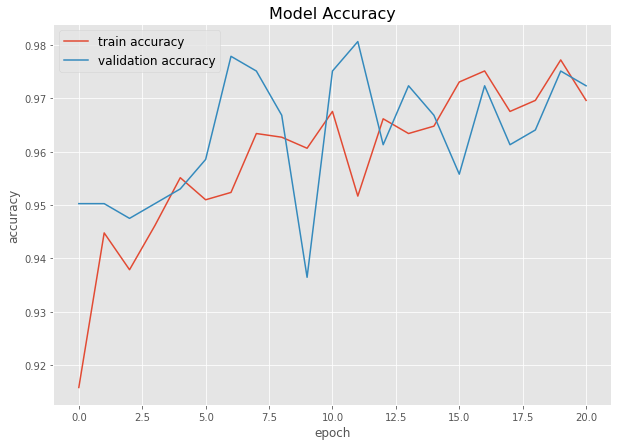

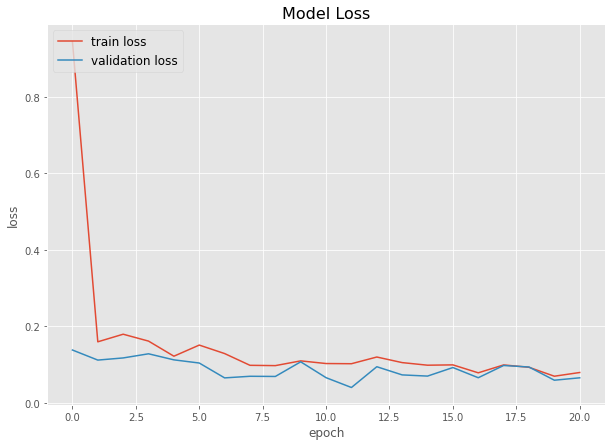

In [14]:
# summarize history for accuracy
plt.style.use("ggplot")
plt.figure(figsize=(10,7))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', fontsize = 16)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'validation accuracy'], loc='upper left', fontsize = 12)
plt.show()

# summarize history for loss
plt.figure(figsize=(10,7))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', fontsize = 16)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'], loc='upper left', fontsize = 12)
plt.show()

##Model Evaluation on an unseen data 

In [50]:
# # set the path to the test dir
TEST_DATADIR = '/content/data/test'
test_data_generator = ImageDataGenerator(rescale=1./255)

test_generator = test_data_generator.flow_from_directory(TEST_DATADIR,
                                                target_size=(150,150),
                                                batch_size = 32,
                                                shuffle=False,
                                                class_mode = 'binary')

Found 484 images belonging to 2 classes.


In [51]:
# get the labels of the test data
y_test = test_generator.classes

In [52]:
# predicting labels for the test images
predictions = model.predict_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


In [57]:
# evaluate the model loss, accuracy and auc score on the test dataset
from sklearn.metrics import log_loss
loss = log_loss(y_test, predictions.astype(np.float64))

from sklearn.metrics import roc_auc_score
acc = roc_auc_score(y_test, predictions>0.8)

from sklearn.metrics import accuracy_score
roc = accuracy_score(y_test, predictions>0.8)

print(' Testing loss:',Fore.BLUE + '%.4f' %loss)
print(Fore.BLACK,'Testing Accuracy:',Fore.GREEN + '%.2f' %(acc*100)+ '%')
print(Fore.BLACK,'Testing ROC SCORE:',Fore.LIGHTRED_EX + '%.2f' %(roc*100)+ '%')

In [59]:
# confusion matrix
print(confusion_matrix(y_test, predictions>0.8))

[[160   7]
 [  3 314]]


In [60]:
# classification report
print(classification_report(y_test, predictions>0.8))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       167
           1       0.98      0.99      0.98       317

    accuracy                           0.98       484
   macro avg       0.98      0.97      0.98       484
weighted avg       0.98      0.98      0.98       484



##Saving the Model

In [61]:
# saving the model in order to reuse it at a later point
model.save("covid_prediction.h5")